In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch
 
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )
\end{aligned}
$$


In [ ]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(1):
        # NumPy data for CVXPY reference
        A2_np = np.random.randn(m, n)
        A1_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = A1_np @ Y0_np.T
        G2_np = A2_np @ Y0_np
        beta = 0.5
        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A2_np, A1_np, beta)

        # Torch tensors
        A2 = torch.from_numpy(A2_np).to(torch.float32).to(device)
        A1 = torch.from_numpy(A1_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        A_linop = attn_linop_from_matrices(A1, A2)
        Grad = torch.cat([G1, G2], dim=0)

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A_linop=A_linop, Grad=Grad,
            max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0,
            stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball_linop,
            diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            torch.trace(Z_t[:m, :].T @ G1 + Z_t[m:, :].T @ G2).item(),
            atol=1e-3,
            rtol=1e-3,
        )
        assert torch.max(torch.abs(A_linop.matvec(Z_t))).item() <= beta + 1e-2 \
           and np.max( np.abs(Z0_1.T @ A1_np + A2_np.T @ Z0_2)) <= beta + 1e-3
print("PASSED")

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


PASSED


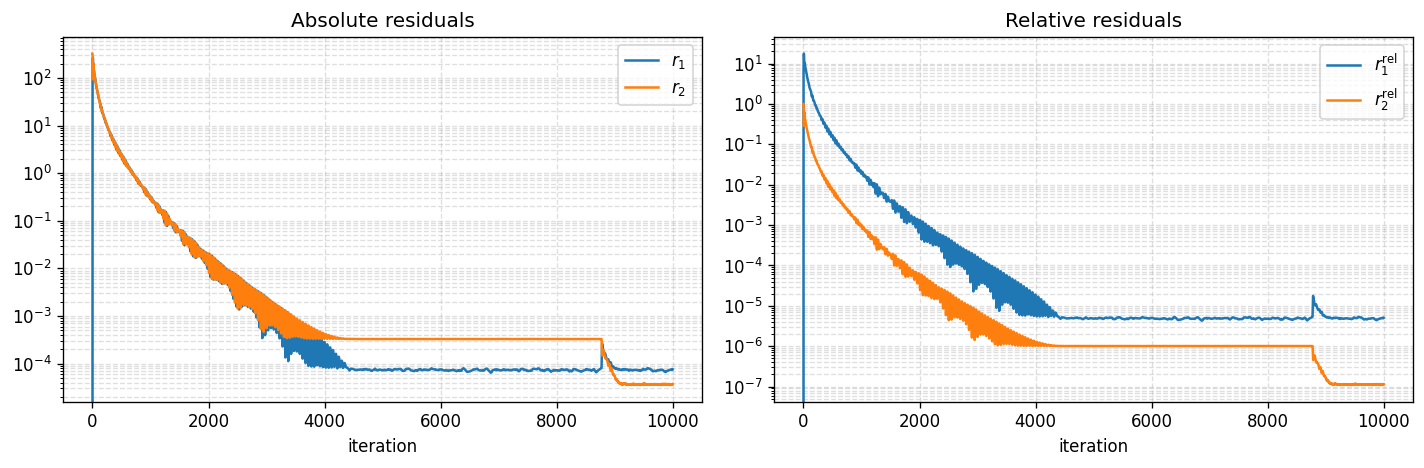

In [4]:
plot_residuals(residuals)

## Dual feasibility checks

In [5]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(1):
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        A = torch.from_numpy(A_np).to(torch.float64)
        B = torch.from_numpy(B_np).to(torch.float64)
        G1 = torch.from_numpy(G1_np).to(torch.float64)
        G2 = torch.from_numpy(G2_np).to(torch.float64)

        _, res1 = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
        _, res2 = Y_dual_feasible(A1=B.to(torch.float32), A2=A.to(torch.float32), G1=G1.to(torch.float32), G2=G2.to(torch.float32), method="lsqr", maxit=1000)
        print("residual:", res1, "residual (float32):", res2)

30x60
residual: {'res_C': 8.160342285959978e-08, 'res': 8.857393053288813e-07, 'iter': 48} residual (float32): {'res_C': 7.020196125353266e-08, 'res': 7.619855670017397e-07, 'iter': 49}
60x30
residual: {'res_C': 6.953684854653945e-08, 'res': 8.447558078028233e-07, 'iter': 31} residual (float32): {'res_C': 7.120892575254653e-08, 'res': 8.650687433796371e-07, 'iter': 31}
60x60
residual: {'res_C': 7.160526240203104e-08, 'res': 9.649153867261586e-07, 'iter': 346} residual (float32): {'res_C': 8.274576150485441e-08, 'res': 1.1150388904321536e-06, 'iter': 353}


In [ ]:
for (m, n) in [(500, 500)]: 
    # NumPy data for CVXPY reference
    A_np = np.random.randn(m, n)
    B_np = np.random.randn(m, n)
    Y0_np = np.random.randn(n, n)
    G1_np = B_np @ Y0_np.T
    G2_np = A_np @ Y0_np

    beta = 0.5 
    # Torch tensors
    A2 = torch.from_numpy(A_np).to(torch.float32).to(device)
    A1 = torch.from_numpy(B_np).to(torch.float32).to(device)
    G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
    G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

    Y0, dual_res = Y_dual_feasible(A1=A1, A2=A2, G1=G1, G2=G2, method="lsqr", maxit=1000) 
    print(f"{dual_res=}")

    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    A_linop = attn_linop_from_matrices(A1, A2)
    Grad = torch.cat([G1, G2], dim=0)

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
        prox_h_conj, A_linop=A_linop, Grad=Grad,
        max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0, Y0=Y0,
        stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball_linop,
        diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)


dual_res={'res_C': 1.601339341686501e-07, 'res': 6.196964202845008e-06, 'iter': 1000}


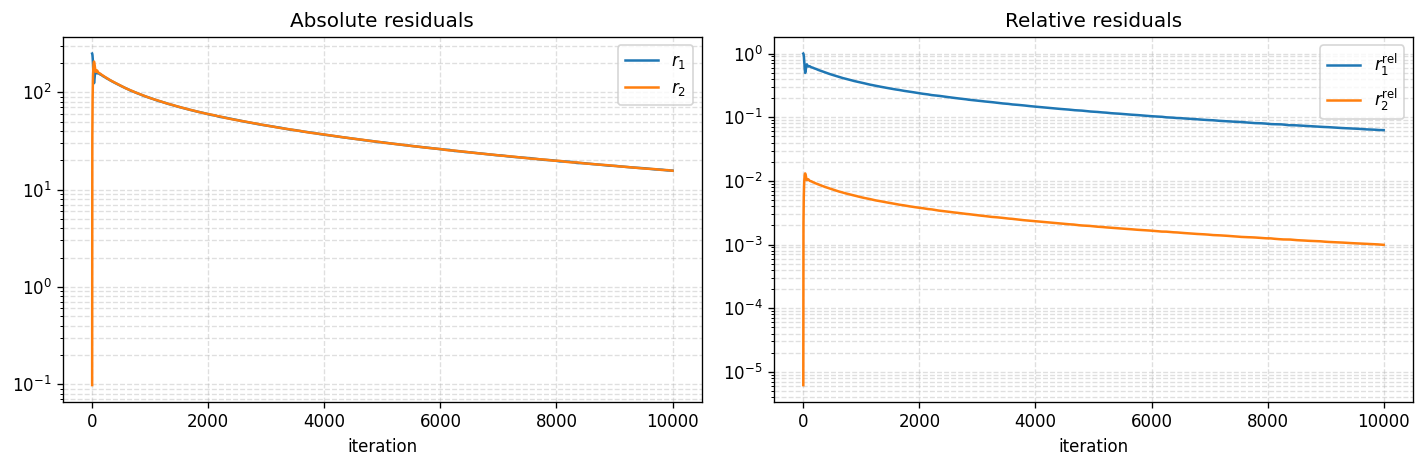

In [7]:
plot_residuals(residuals)

In [8]:
max(residuals["r1_rel"][:50]), max(residuals["r2_rel"][:50]), min(residuals["r1_rel"][:50]), min(residuals["r2_rel"][:50])

(1.0, 0.013094419753524551, 0.4963789367675781, 6.196964202845008e-06)

## reHPDHG


In [ ]:
for (m, n) in [(30, 60), (60, 30), (30, 30)]:
    for _ in range(1):
        # NumPy data for CVXPY reference
        A1_np = np.random.randn(m, n).astype(np.float64)
        A2_np = np.random.randn(m, n).astype(np.float64)
        Y0_np = np.random.randn(n, n).astype(np.float64)
        G1_np = A1_np @ Y0_np.T
        G2_np = A2_np @ Y0_np
        # Torch tensors
        A2 = torch.from_numpy(A2_np).to(torch.float64).to(device)
        A1 = torch.from_numpy(A1_np).to(torch.float64).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float64).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float64).to(device)

        beta = 0.5
        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A2_np, A1_np, beta)
        Y_star_torch = torch.tensor(Y_star, dtype=A1.dtype, device=device)
        Z_star_1_torch = torch.tensor(Z0_1, dtype=A1.dtype, device=device)
        Z_star_2_torch = torch.tensor(Z0_2, dtype=A1.dtype, device=device)
        AZ = Z_star_1_torch.T @ A1 + A2.T @ Z_star_2_torch 
        print(pd_residuals_infty_ball(A=A2, B=A1, Y=Y_star_torch, Z1=Z_star_1_torch, Z2=Z_star_2_torch, 
                                      G1=G1, G2=G2, beta=beta, mu=0))

        
        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        A_linop = attn_linop_from_matrices(A1, A2)
        Grad = torch.cat([G1, G2], dim=0)

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A_linop=A_linop, Grad=Grad,
            max_iter=7000, eps_abs=1e-8, eps_rel=1e-8,
            h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball_linop,
            diag_scaling=False, equilibration=False, reflected_halpern=True, enable_restart=True)

        print(pd_residuals_max_ball_linop(A_linop, Y_t, Z_t, Grad, beta, mu=0))

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            torch.trace(Z_t[:m, :].T @ G1 + Z_t[m:, :].T @ G2).item(),
            atol=1e-3,
            rtol=1e-3,
        )
        assert torch.max(torch.abs(A_linop.matvec(Z_t))).item() <= beta + 1e-2 \
           and np.max( np.abs(Z0_1.T @ A1_np + A2_np.T @ Z0_2)) <= beta + 1e-3
print("PASSED")

(8.514135240015856, 0.28380450800052853, 1.8483056350073426e-13, 3.8988833536686126e-16)
(0.06542517166431701, 0.0021808390554772334, 0.008104943456895435, 1.709686348837508e-05)
(1.7628768863891457e-07, 1.1752512575927638e-08, 1.0228019764954252e-13, 2.8735664861695704e-16)
(2.0509248226836457e-14, 1.3672832151224304e-15, 2.1317141530676134e-13, 5.989059944269518e-16)
(8.694107143911092e-08, 5.7960714292740615e-09, 9.982776493881563e-14, 4.443789155492681e-16)
(6.986839980192953e-06, 4.657893320128635e-07, 0.019185989495690517, 8.540559042927676e-05)
PASSED


In [14]:
Grad.dtype, A1.dtype, A2.dtype

(torch.float64, torch.float64, torch.float64)

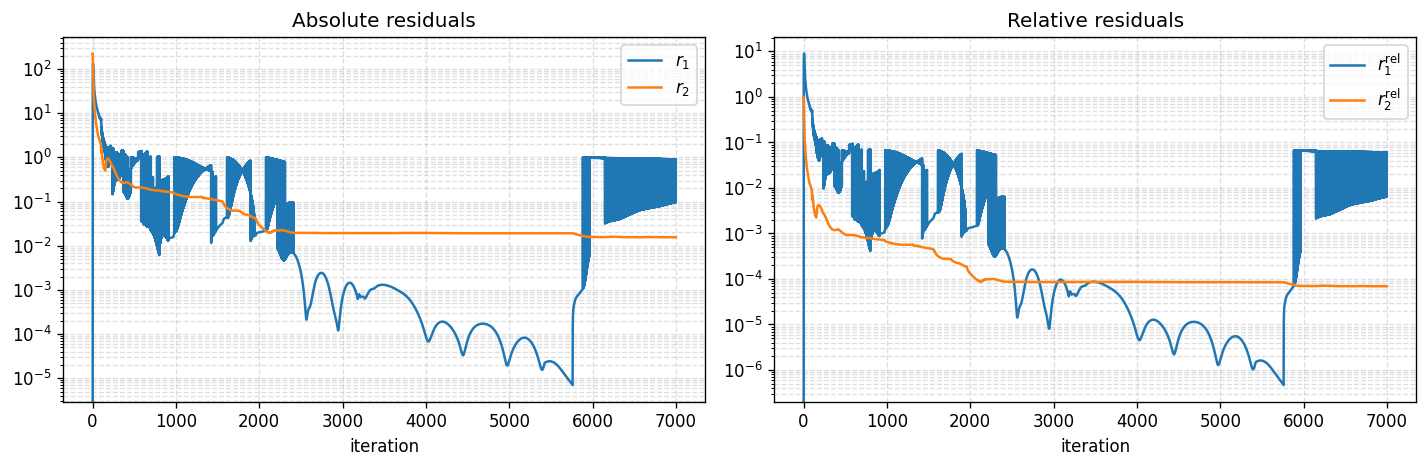

In [15]:
plot_residuals(residuals)

## Dual feasibility checks $\|\mathcal{A}^*(Y) + G\|_F$

In [16]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(1):
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        A = torch.from_numpy(A_np).to(torch.float64)
        B = torch.from_numpy(B_np).to(torch.float64)
        G1 = torch.from_numpy(G1_np).to(torch.float64)
        G2 = torch.from_numpy(G2_np).to(torch.float64)

        _, res1 = Y_dual_feasible(A2=A, A1=B, G1=G1, G2=G2, method="lsqr")
        _, res2 = Y_dual_feasible(A2=A.to(torch.float32), A1=B.to(torch.float32), 
                                  G1=G1.to(torch.float32), G2=G2.to(torch.float32), method="lsqr")
        print("residual:", res1["res"], "residual (float32):", res2["res"])

30x60
residual: 8.415471602330354e-07 residual (float32): 9.895897068425453e-07
60x30
residual: 9.526411964925948e-07 residual (float32): 9.79920349219924e-07
60x60
residual: 9.745612237008768e-07 residual (float32): 1.1101104571829793e-06


In [17]:
all_res = {}

settings = {"vanilla": {"diag_scaling": False, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "rehpdhg": {"diag_scaling": False, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "diag_scaling": {"diag_scaling": True, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "equilibration": {"diag_scaling": False, "equilibration": True, "reflected_halpern":False, "enable_restart": False},
            "repdhg_ds": {"diag_scaling": True, "equilibration": False, "reflected_halpern":True, "enable_restart": False},
            "ada_rehpdhg": {"diag_scaling": False, "equilibration": False, "reflected_halpern":True, "enable_restart": True},
            "ada_rehpdhg_ds": {"diag_scaling": True, "equilibration": False, "reflected_halpern":True, "enable_restart": True},
           }
m = n = 500
# NumPy data for CVXPY reference
A2_np = np.random.randn(m, n)
A1_np = np.random.randn(m, n)
Y0_np = np.random.randn(n, n)
G1_np = A1_np @ Y0_np.T
G2_np = A2_np @ Y0_np

beta = 0.5 
# Torch tensors
A2 = torch.from_numpy(A2_np).to(torch.float32).to(device)
A1 = torch.from_numpy(A1_np).to(torch.float32).to(device)
G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

for setting in settings:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    A_linop = attn_linop_from_matrices(A1, A2)
    Grad = torch.cat([G1, G2], dim=0)

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
        prox_h_conj, A_linop=A_linop, Grad=Grad,
        max_iter=10**4, eps_abs=1e-8, eps_rel=1e-8,
        stopping=False, 
        h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball_linop,
        diag_scaling=settings[setting]["diag_scaling"], 
        equilibration=settings[setting]["equilibration"],
        reflected_halpern=settings[setting]["reflected_halpern"],
        enable_restart=settings[setting]["enable_restart"],
        verbose=True
    )
    all_res[setting] = residuals

    # Back to NumPy for comparison
    Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()


||A||_op <= 7.0670e+02
||A||_op <= 7.0670e+02
||A||_op <= 7.0670e+02
||A||_op <= 2.6605e+02
||A||_op <= 7.0670e+02
||A||_op <= 7.0670e+02
[RESTART] iter= 100 primal_weight=3.7891e+00 r_prim=8.308e+00 r_dual=6.640e-02
[RESTART] iter= 157 primal_weight=5.0388e-01 r_prim=4.227e+00 r_dual=3.399e-02
[RESTART] iter= 246 primal_weight=1.6080e+00 r_prim=1.851e+00 r_dual=5.065e-02
[RESTART] iter= 385 primal_weight=6.9376e-01 r_prim=1.990e+00 r_dual=1.911e-02
[RESTART] iter= 602 primal_weight=9.8664e-01 r_prim=4.844e-01 r_dual=1.151e-02
[RESTART] iter= 941 primal_weight=1.0306e+00 r_prim=2.474e-01 r_dual=3.306e-03
[RESTART] iter=1471 primal_weight=1.0602e+00 r_prim=1.063e-01 r_dual=1.251e-03
[RESTART] iter=2299 primal_weight=9.6239e-01 r_prim=5.730e-02 r_dual=4.164e-04
[RESTART] iter=3593 primal_weight=9.0203e-01 r_prim=4.286e-02 r_dual=1.592e-04
[RESTART] iter=5615 primal_weight=9.3015e-01 r_prim=3.114e-02 r_dual=6.182e-05
[RESTART] iter=8774 primal_weight=6.4540e-01 r_prim=2.217e-02 r_dual=3.0

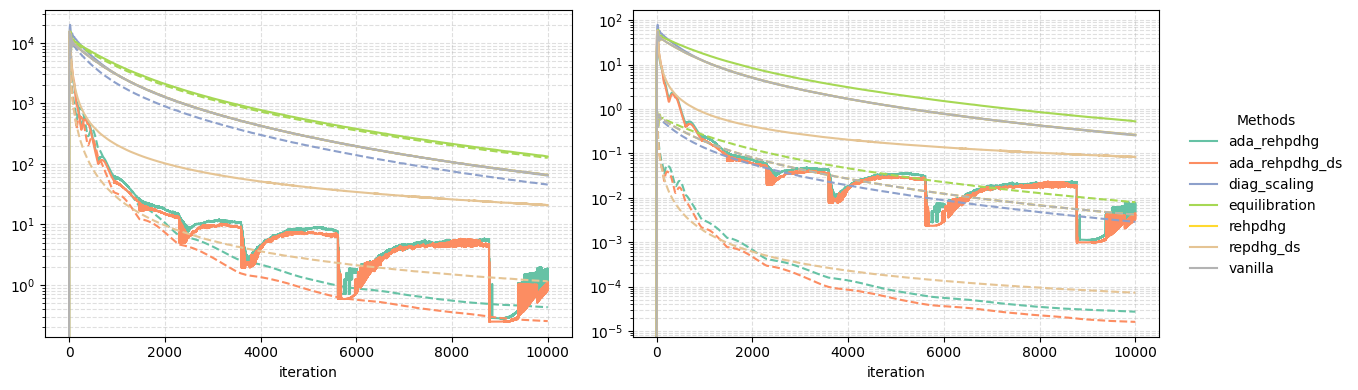

In [18]:
plot_residuals_compare(all_res, dpi=100, dual_scale=True)